In [ ]:
#default_exp eda

In [ ]:
#hide
import transformers

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

import Hasoc.config as config
import Hasoc.utils.utils as utils
import Hasoc.utils.engine as engine
import Hasoc.model.model as model
import Hasoc.dataset.dataset as dataset

from functools import partial
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
#hide
df = pd.read_csv(config.DATA_PATH/'fold_df.csv')

In [ ]:
#hide
df.head(2)

,tweet_id,text,task1,task2,ID,kfold_task1,kfold_task2
0,1.126953e+18,"We need a word for ‘going somewhere alone,sitt...",NOT,NONE,hasoc_2020_en_1503,2,0
1,1.123482e+18,RT @RiverCityLabs: Come and work from our spac...,NOT,NONE,hasoc_2020_en_3570,2,0


In [ ]:
#hide
le = LabelEncoder()
le.fit_transform(df.task2)
le.classes_

array(['HATE', 'NONE', 'OFFN', 'PRFN'], dtype=object)

In [ ]:
#hide
df['task2_encoded'] = le.transform(df.task2.values)

In [ ]:
#hide
d = dataset.BertDataset(df.text.values, df.task2_encoded.values)

In [ ]:
#hide
d[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([ 101, 2057, 2342, 1037, 2773, 2005, 1520, 2183, 4873, 2894, 1010, 3564,
         1998, 3403, 2005, 2070, 7985, 2000, 3921, 2017, 1521,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 'targets': tensor([0, 1, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0

In [ ]:
#hide
train_dl = utils.create_loader(df.text.values, df.task1_encoded, bs=config.TRAIN_BATCH_SIZE)
valid_dl = utils.create_loader(df.text.values, df.task1_encoded, bs=config.VALID_BATCH_SIZE)

In [ ]:
train_dl.batch_size

16

In [ ]:
#hide
next(iter(train_dl))

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[  101,  2057,  2342,  ...,     0,     0,     0],
         [  101, 19387,  1030,  ...,     0,     0,     0],
         [  101,  2017,  1005,  ...,     0,     0,     0],
         ...,
         [  101, 19387,  1030,  ...,     0,     0,     0],
         [  101, 19387,  1030,  ...,     0,     0,     0],
         [  101,  1030,  1035,  ...,     0,     0,     0]]),
 'targets': tensor([[0, 1, 0, 0],
         [0, 1, 0, 0],
         [0, 1, 0, 0],
         [0, 1, 0, 0],
         [0, 1, 0, 0],
         [1, 0, 0, 0],
         [0, 0, 1, 0],
         [1, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 1, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 1],
         [0, 1, 0

In [ ]:
#hide
modeller = model.HasocModel(len(le.classes_))

In [ ]:
#hide
model_params = list(modeller.named_parameters())

In [ ]:
#hide
# we don't want weight decay for these
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']

optimizer_params = [
    {'params': [p for n, p in model_params if n not in no_decay], 
    'weight_decay':0.001},
    #  no weight decay should be applied
    {'params': [p for n, p in model_params if n in no_decay],
    'weight_decay':0.0}
]

In [ ]:
#hide
lr = config.LR

In [ ]:
#hide
optimizer = AdamW(optimizer_params, lr=lr)

In [ ]:
#hide
num_train_steps = int(len(df) / config.TRAIN_BATCH_SIZE * config.NUM_EPOCHS)

In [ ]:
#hide
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, 
                                                num_warmup_steps=0, 
                                                num_training_steps=num_train_steps)

In [ ]:
#hide
fit = engine.BertFitter(modeller, (train_dl, valid_dl), optimizer, nn.CrossEntropyLoss(), partial(f1_score, average='macro'), config.DEVICE, scheduler=scheduler)

epoch,train_loss,valid_loss,log_metric,time


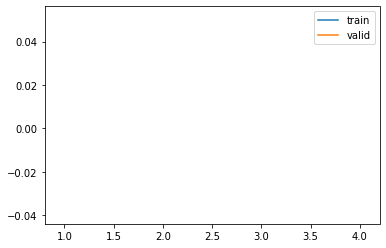

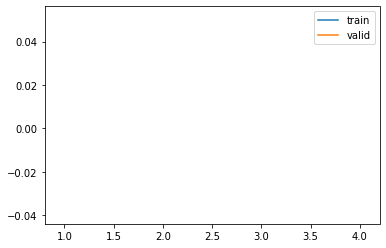

In [ ]:
#hide
fit.fit(config.NUM_EPOCHS, model_path=None)

In [ ]:
#hide
b = next(iter(train_dl))
targs = b.pop('targets')

In [ ]:
#hide
with torch.no_grad():
    out = modeller(**b)

In [ ]:
#hide
targs.shape, out.shape

(torch.Size([16, 4]), torch.Size([16, 4]))

In [ ]:
#hide
(out.softmax(dim=-1)>=0.5), targs

(tensor([[ True, False, False, False],
         [False, False, False, False],
         [ True, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [False, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [False, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [False, False, False, False],
         [ True, False, False, False],
         [False, False, False, False]]), tensor([[0, 1, 0, 0],
         [0, 1, 0, 0],
         [0, 1, 0, 0],
         [0, 1, 0, 0],
         [0, 1, 0, 0],
         [1, 0, 0, 0],
         [0, 0, 1, 0],
         [1, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 1, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 1],
         [0, 1, 0, 0]]))

In [ ]:
out.softmax(dim=-1)

tensor([[0.5213, 0.1170, 0.1264, 0.2353],
        [0.4784, 0.1322, 0.1238, 0.2656],
        [0.5430, 0.0879, 0.1310, 0.2381],
        [0.4710, 0.0646, 0.0771, 0.3873],
        [0.4497, 0.0865, 0.1655, 0.2983],
        [0.4522, 0.0795, 0.1608, 0.3074],
        [0.5375, 0.0764, 0.1220, 0.2642],
        [0.5303, 0.0980, 0.1066, 0.2651],
        [0.6004, 0.0668, 0.1089, 0.2239],
        [0.6011, 0.1056, 0.0844, 0.2089],
        [0.4491, 0.0938, 0.1805, 0.2766],
        [0.5747, 0.1029, 0.1526, 0.1697],
        [0.5391, 0.0974, 0.1413, 0.2223],
        [0.4676, 0.1382, 0.1530, 0.2412],
        [0.5239, 0.0892, 0.1016, 0.2853],
        [0.4726, 0.1453, 0.1046, 0.2774]])

In [ ]:
out.T.shape

torch.Size([4, 16])

In [ ]:
out.softmax(dim=-1).max(1)[0].T.expand((*out.T.shape)).T

tensor([[0.5213, 0.5213, 0.5213, 0.5213],
        [0.4784, 0.4784, 0.4784, 0.4784],
        [0.5430, 0.5430, 0.5430, 0.5430],
        [0.4710, 0.4710, 0.4710, 0.4710],
        [0.4497, 0.4497, 0.4497, 0.4497],
        [0.4522, 0.4522, 0.4522, 0.4522],
        [0.5375, 0.5375, 0.5375, 0.5375],
        [0.5303, 0.5303, 0.5303, 0.5303],
        [0.6004, 0.6004, 0.6004, 0.6004],
        [0.6011, 0.6011, 0.6011, 0.6011],
        [0.4491, 0.4491, 0.4491, 0.4491],
        [0.5747, 0.5747, 0.5747, 0.5747],
        [0.5391, 0.5391, 0.5391, 0.5391],
        [0.4676, 0.4676, 0.4676, 0.4676],
        [0.5239, 0.5239, 0.5239, 0.5239],
        [0.4726, 0.4726, 0.4726, 0.4726]])

In [ ]:
(out.softmax(dim=-1) >= out.softmax(dim=-1).max(1)[0].T.expand((*out.T.shape)).T)

tensor([[ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False]])

In [ ]:
(out.softmax(dim=-1)>=0.5)

tensor([[ True, False, False, False],
        [False, False, False, False],
        [ True, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [False, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [False, False, False, False],
        [ True, False, False, False],
        [False, False, False, False]])

In [ ]:
targs.shape

torch.Size([16, 4])

In [ ]:
#hide
f1_score(targs, (out.softmax(dim=-1) >= out.softmax(dim=-1).max(1)[0].T.expand((*out.T.shape)).T), average='macro')

0.05555555555555555

In [ ]:
#hide
f1_score(targs.argmax(dim=-1), out.argmax(dim=-1), average='macro')

0.05555555555555555

In [ ]:
#hide
f1_score(targs, (out.softmax(dim=-1)>=0.5), average='macro')

0.04545454545454545